# TODO
1. ~~wyznaczanie pojedynczych puzzli~~ - Mikołaj
2. ~~ponumerowanie puzzli~~ - Mikołaj
3. ~~wyznaczanie krawędzi~~ - Bartosz
4. ~~wyznaczanie narożników~~ - Bartosz
5. wykorzystanie narożników do podziału krawędzi na 4 boki
6. szukanie patternów/dopasowywanie krawędzi i/lub kolorów

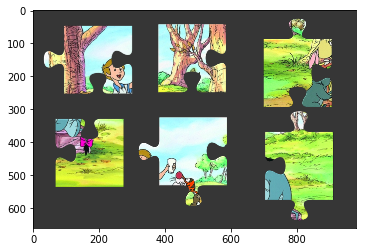

In [57]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from random import randint

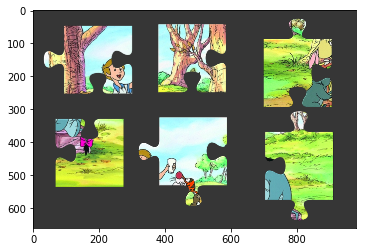

In [58]:
def draw(img):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))

img = cv2.imread(os.path.join('img', 'puchatek_puzzle_1.png'))
img = cv2.copyMakeBorder(img, 20, 20, 20, 20, cv2.BORDER_REPLICATE, None)
img2 = cv2.imread(os.path.join('img', 'puchatek_puzzle_2.png'))

draw(img)


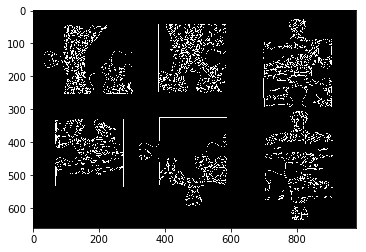

In [60]:
image = cv2.imread(os.path.join('img', 'puchatek_puzzle_1.png'))
image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_REPLICATE, None)
edged = cv2.Canny(image, 10, 250)
draw(edged)


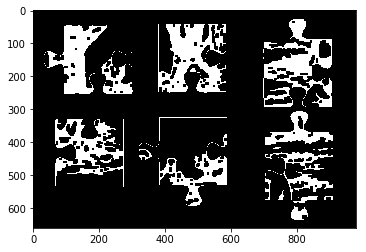

In [61]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
draw(closed)


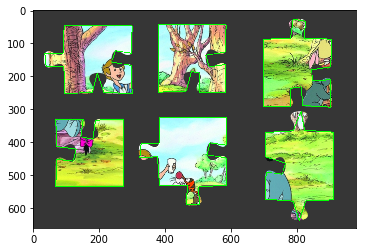

In [62]:
im2, cnts, hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)
draw(image)


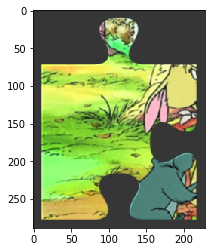

In [63]:

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    if w>50 and h>50:
        new_img=img[y-10:y+h+10, x-10:x+w+10]
        draw(new_img)


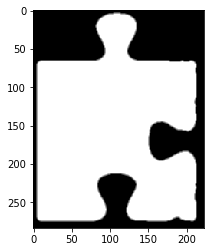

In [65]:
puzz = img
puzz2= img
BLACK = [0, 0, 0]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    if w>50 and h>50:
        value = [randint(0, 255), randint(0, 255), randint(0, 255)]
        puzz = img[y-5:y+h+10, x-5:x+w+10]
        
loc = cv2.cvtColor(puzz, cv2.COLOR_BGR2GRAY)
loc = cv2.medianBlur(loc, ksize=3)
loc = cv2.threshold(loc, 60, 255, cv2.THRESH_BINARY)[1]
loc = cv2.dilate(loc, (5,5))
loc = cv2.medianBlur(loc, ksize=9)
loc = cv2.blur(loc, ksize=(3, 3))

draw(loc)

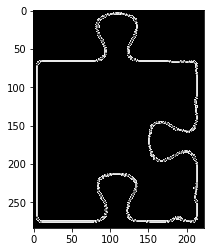

In [66]:
dst = cv2.cornerHarris(np.float32(loc),2,3,0.04)
dst = cv2.dilate(dst,None)
draw(np.uint8(dst))

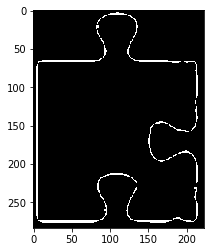

In [67]:
l = np.zeros((dst.shape[0], dst.shape[1]), dtype=np.uint8)

l[dst<0.03*np.min(dst)]=[255]
l[dst>0.03*np.max(dst)]=[255]

draw(l)

In [68]:
lines = cv2.HoughLines(np.uint8(l), 0.1, np.pi/180, 100)

In [69]:
li = []
for el in lines:
    li.append(el[0])

wyn = [[li[0]]]    

res = [li[0]]

for i in range(1, len(li)):
    flag = False
    for k in range(len(res)):
        if (res[k][0]-5 < li[i][0] and li[i][0] < res[k][0]+5) and (res[k][1]-5 < li[i][1] and li[i][1] < res[k][1]+5):
            wyn[k].append(li[i])
            flag = True
    if not flag:
        wyn.append([li[i]])
        res.append(li[i])

moments = []
        
for el in wyn:
    a, b, c = 0, 0, 0
    for e in el:
        a += e[0]
        b += e[1]
        c += 1
    moments.append([a/c, b/c])
    
moments

[[4.9500002066294355, 0.0],
 [212.4499969482422, 0.0],
 [65.95000457763672, 1.5707963705062866],
 [274.45001220703125, 1.5707963705062866]]

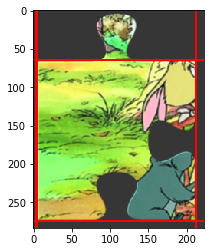

In [70]:
aaaa = puzz.copy()
points = []

for el in moments:
    rho,theta = el[0], el[1]
    a = np.cos(theta)
    b = np.sin(theta)
    
    x0 = a*rho
    y0 = b*rho
    
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    points.append([[x1,y1],[x2,y2]])
    
    cv2.line(aaaa, (x1, y1), (x2,y2), (0,0,255), 2)
    
draw(aaaa)

In [71]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) #Typo was here

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [72]:
corners = set()
for i in range(len(points)):
    for k in range(len(points)):
        lx = line_intersection(points[i], points[k])
        if lx is not None:
            corners.add(lx)
            
corners = np.array(list(corners), dtype=np.int32)
corners

array([[  4, 274],
       [212, 274],
       [  4,  65],
       [212,  65]])

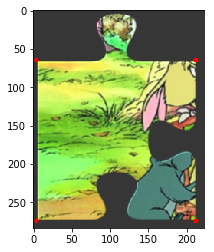

In [51]:
aaaa = puzz.copy()
for el in corners:
    cv2.circle(aaaa, (el[0], el[1]), 3, (0,0,255), -1)
draw(aaaa)